In [ ]:
import gensim.downloader as api
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import pickle as pkl
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import os

: 

In [2]:
glove_vectors = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
word2index = pkl.load(open("../word2index.pkl", "rb"))
embeddings_50 = pkl.load(open("../embeddings/embeddings_50.pkl", "rb"))
embeddings_50_normalized = pkl.load(open("../embeddings/embeddings_50_normalized.pkl", "rb"))

In [17]:
glove_vocab = set(glove_vectors.index_to_key)
common_vocab = set(word2index.keys()).intersection(glove_vocab)

In [18]:
print("Number of words in common vocab: ", len(common_vocab))
print("Number of words in SVD vocab: ", len(word2index))
print("Number of words in Glove vocab: ", len(glove_vocab))

Number of words in common vocab:  95505
Number of words in SVD vocab:  162625
Number of words in Glove vocab:  400000


In [ ]:
glove_word2index = {}
glove_embeddings = np.zeros((len(common_vocab), 50))
for i, word in enumerate(common_vocab):
    glove_embeddings[i] = glove_vectors[word]
    glove_word2index[word] = i


In [29]:
man = glove_word2index['man']
woman = glove_word2index['woman']
boy = glove_word2index['boy']
girl = glove_word2index['girl']

def cosine(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

print(f"Cosine Similarity - {cosine(glove_embeddings[woman], glove_embeddings[man] - glove_embeddings[boy] + glove_embeddings[girl])}")

Cosine Similarity - 0.9389293774817409


### Word Similarity

In [ ]:
with open ('../ord_similarity/combined.tab') as f:
    wordsim = [line.strip().split() for line in f]

with open ('../word_similarity/SimLex-999/SimLex-999.txt') as f:
    simlex = [line.strip().split() for line in f]

wordsim = wordsim[1:]
simlex = simlex[1:]
wordsim = [(word1, word2, similarity) for word1, word2, similarity in wordsim]
simlex = [(word1, word2, similarity) for word1, word2, _, similarity, _, _, _, _, _, _ in simlex]

with open ('../word_similarity/MEN/MEN_dataset_lemma_form_full') as f:
    men = [line.strip().split() for line in f]

men = [[line[0][:-2], line[1][:-2], line[2]] for line in men]

In [ ]:
def evaluate_similarity(embeddings, word_to_index, similarity_data):
    predicted_similarities = []
    human_similarities = []

    for word1, word2, human_similarity in similarity_data:
        if word1 in word_to_index and word2 in word_to_index:
            index1 = word_to_index[word1]
            index2 = word_to_index[word2]
            embedding1 = embeddings[index1].reshape(1, -1)
            embedding2 = embeddings[index2].reshape(1, -1)
            cosine_sim = cosine_similarity(embedding1, embedding2)[0, 0]
            predicted_similarities.append(cosine_sim)
            human_similarities.append(float(human_similarity))

    correlation, _ = spearmanr(predicted_similarities, human_similarities)
    return correlation

In [31]:
correlation_simlex = evaluate_similarity(glove_embeddings, glove_word2index, simlex)
correlation_wordsim = evaluate_similarity(glove_embeddings, glove_word2index, wordsim)
correlation_men = evaluate_similarity(glove_embeddings, glove_word2index, men)

print(f"Correlation on SimLex-999: {correlation_simlex}")
print(f"Correlation on WordSim-353: {correlation_wordsim}")
print(f"Correlation on on MEN: {correlation_men}")

Correlation on SimLex-999: 0.26666913163470896
Correlation on WordSim-353: 0.4981419703999633
Correlation on on MEN: 0.6508597838944686


### Analogy

In [ ]:
bats = '../analogy/BATS_3.0'

pairs = {}

for relation in os.listdir(bats):
    for category in os.listdir(os.path.join(bats, relation)):
        if category == 'metadata.json':
            continue
        with open(os.path.join(bats, relation, category)) as f:
            for line in f:
                line = line.strip().split()
                line[0] = line[0].split('/')[0]
                line[1] = line[1].split('/')[0]
                if category[:3] not in pairs:
                    pairs[category[:3]] = []
                pairs[category[:3]].append(line)

In [33]:
def evaluate_analogy(words, word2index, embedding, correctness):
    correct = 0
    total = 0
    cosine = 0
    for pair in words:
        if pair[0] in word2index and pair[1] in word2index and pair[2] in word2index and pair[3] in word2index:
            total += 1
            index1 = word2index[pair[0]]
            index2 = word2index[pair[1]]
            index3 = word2index[pair[2]]
            index4 = word2index[pair[3]]
            embedding1 = embedding[index1].reshape(1, -1)
            embedding2 = embedding[index2].reshape(1, -1)
            embedding3 = embedding[index3].reshape(1, -1)
            embedding4 = embedding[index4].reshape(1, -1)
            difference = embedding2 - embedding1 + embedding3
            similarity = cosine_similarity(difference, embedding4)[0, 0]
            cosine += similarity
            if similarity > correctness:
                correct += 1
    return correct / total, cosine / total, total

In [34]:
words = []

for category in pairs.keys():
    for i in range(0, len(pairs[category]), 2):
        words.append(pairs[category][i] + pairs[category][i + 1])


In [35]:
correctness, cosine, total = evaluate_analogy(words, glove_word2index, glove_embeddings, 0.5)
print(f"Analogy correctness: {correctness}")
print(f"Analogy cosine: {cosine}")
print(f"Analogy total: {total}")

Analogy correctness: 0.6111111111111112
Analogy cosine: 0.5508628847493278
Analogy total: 756


### Visualisation

In [36]:
def cluster_embeddings(embeddings, num_clusters=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=100)
    clusters = kmeans.fit_predict(embeddings)
    return clusters, kmeans.labels_

def reduce_embeddings(embeddings, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, n_iter=700)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings


  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█         | 1/9 [02:13<17:47, 133.42s/it]C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 22%|██▏       | 2/9 [04:58<17:45, 152.21s/it]C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pa

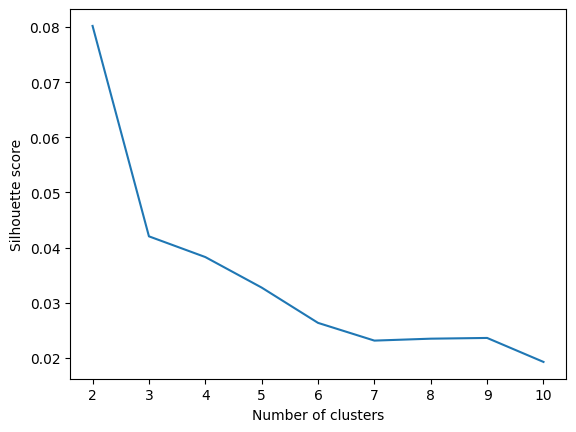

In [ ]:
silhouette_scores = []
clusters_array = []
labels_array = []
for num_clusters in tqdm(range(2, 11)):
    clusters, labels = cluster_embeddings(glove_embeddings, num_clusters)
    clusters_array.append(clusters)
    labels_array.append(labels)
    silhouette_scores.append(silhouette_score(glove_embeddings, labels))

plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


In [38]:
pca_embeddings = reduce_embeddings(glove_embeddings, method='pca')

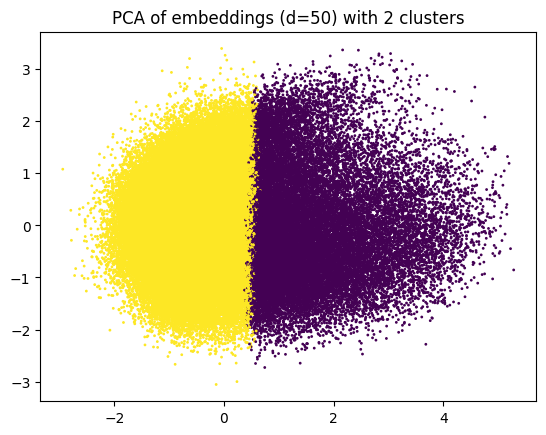

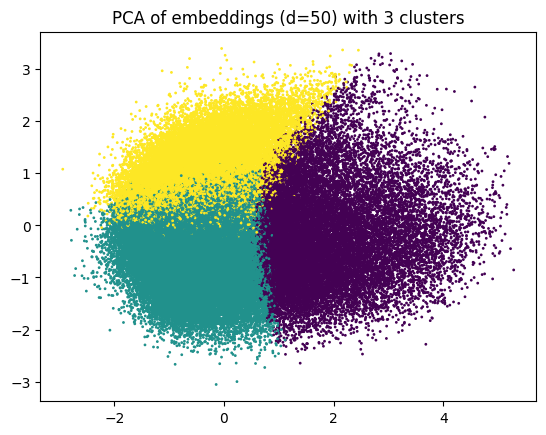

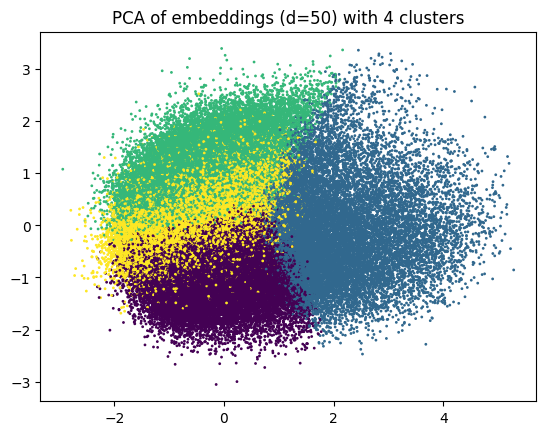

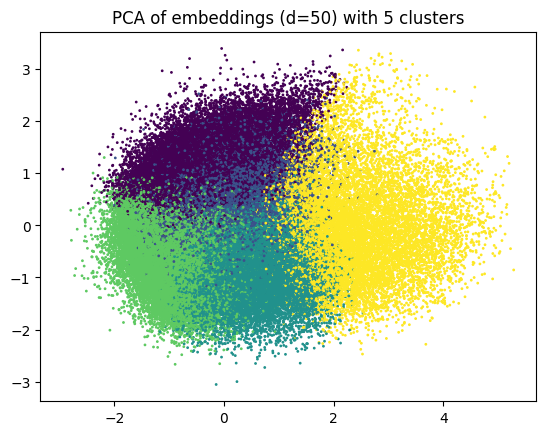

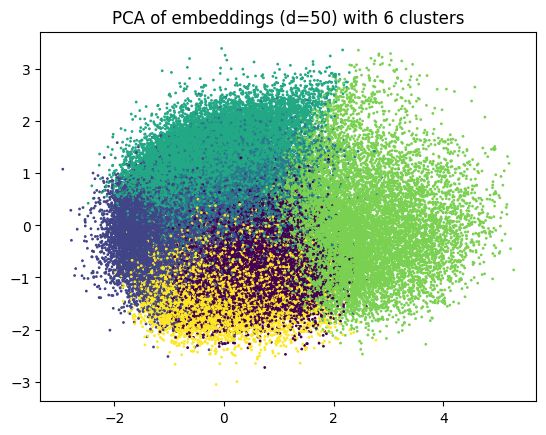

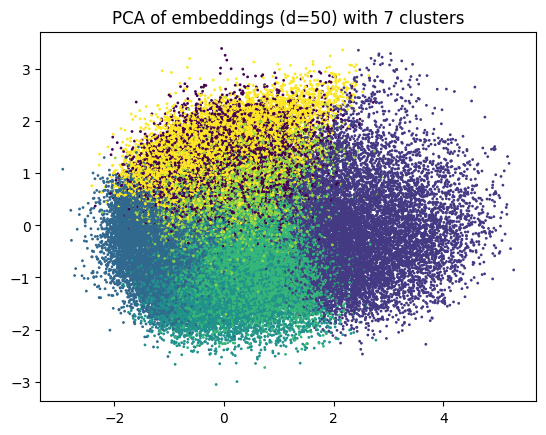

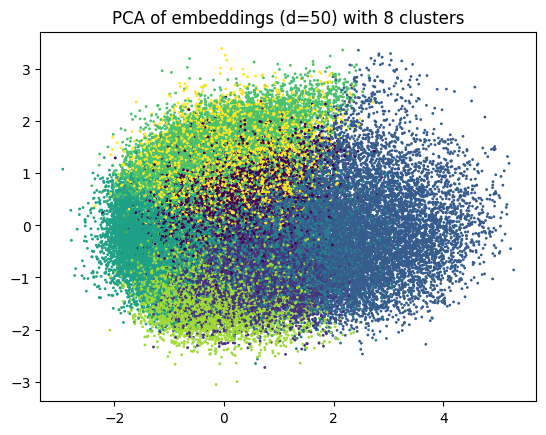

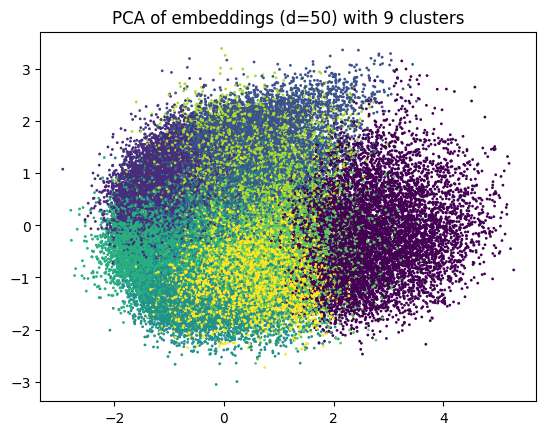

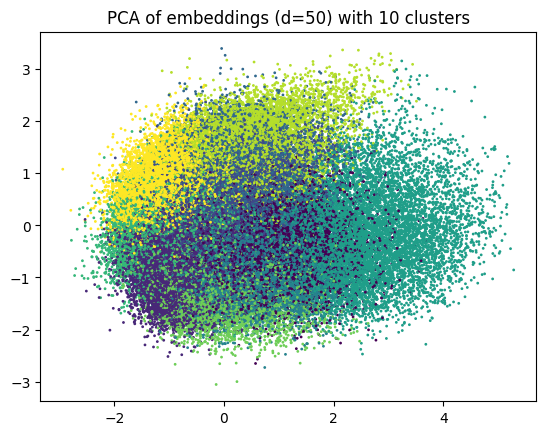

In [39]:
for i in range(9):
    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=clusters_array[i], s=1)
    plt.title(f'PCA of embeddings (d=50) with {i+2} clusters')
    plt.show()

In [40]:
tsne_embeddings = reduce_embeddings(glove_embeddings, method='tsne')

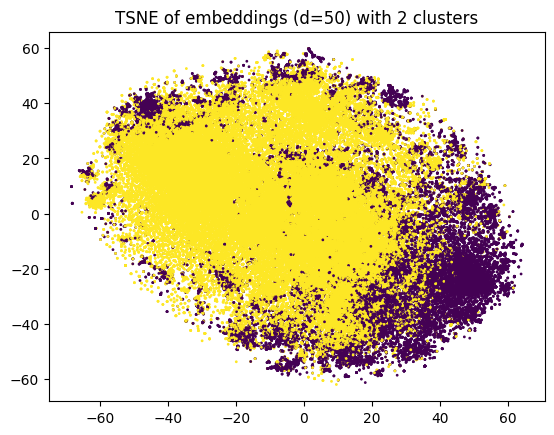

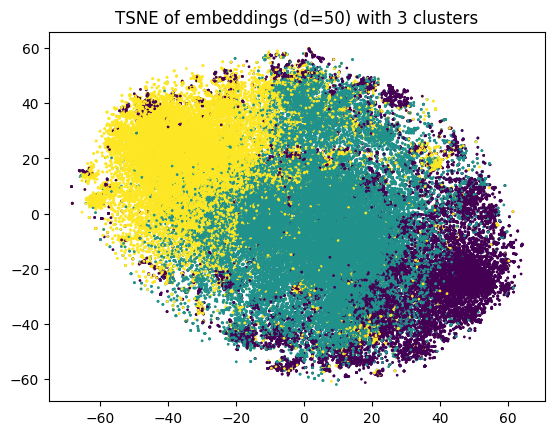

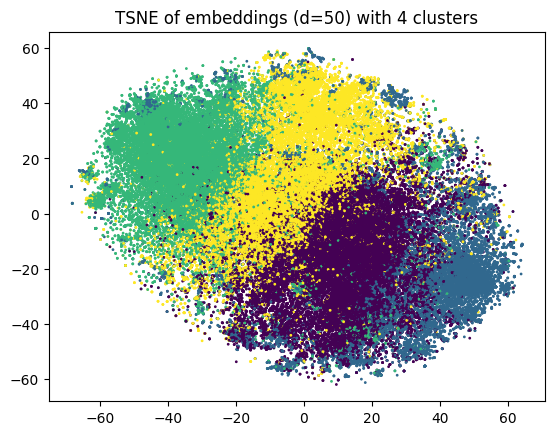

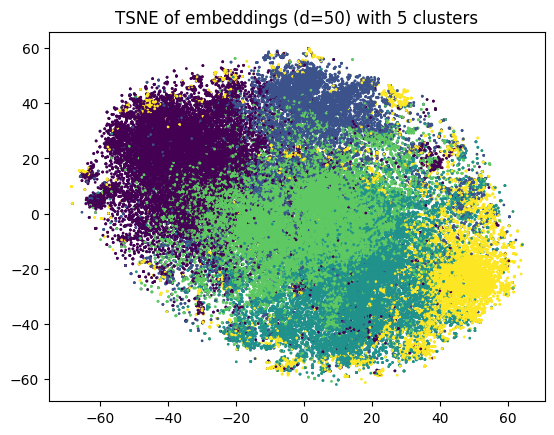

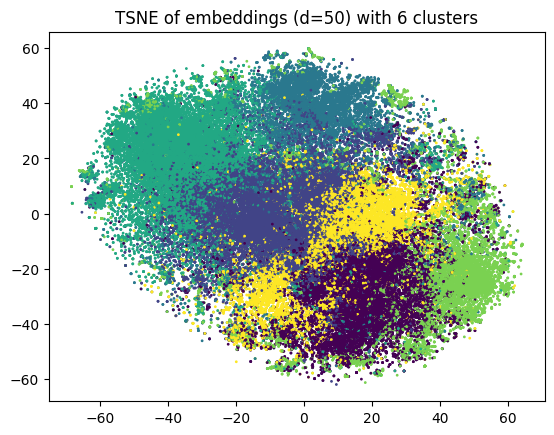

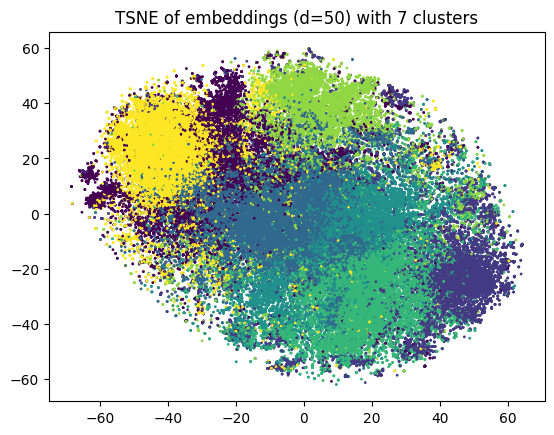

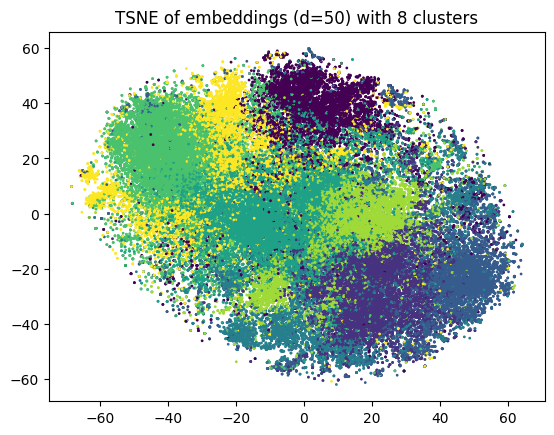

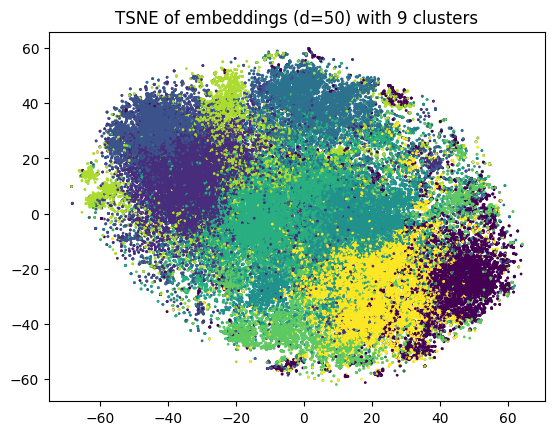

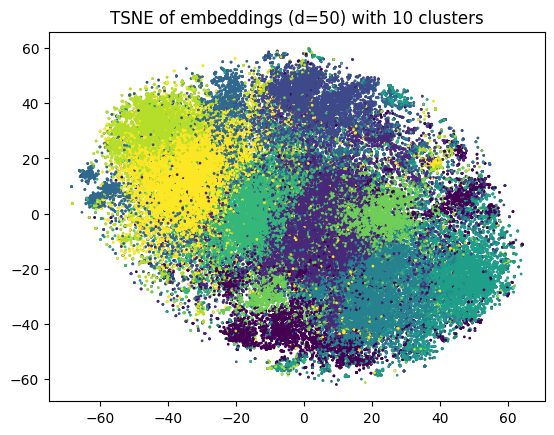

In [41]:
for i in range(9):
    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=clusters_array[i], s=1)
    plt.title(f'TSNE of embeddings (d=50) with {i+2} clusters')
    plt.show()